In [181]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MNIST local update results

Base command (changing k = [1, 4, 10])
```
python cezo_fl_main.py --local-update=4 --dataset=mnist --log-to-tensorboard=True --lr=0.001 --seed=99 --iterations=10000 --num-pert=20 --momentum=0.9 --num-clients=100 --num-sample-clients=10
```

In [182]:
zo_filenames = os.listdir("mnist_zo_fedavg")
fo_filenames = os.listdir("mnist_fo_fedavg")
MODEL_SIZE = 28938

In [183]:
def parse_filename(filename):
    tokens = filename.split("-")
    metadata = {
        tokens[i]: tokens[i+1]
        for i in [2, 4, 6, 8, 10, 12]
    }
    # Cast
    metadata['local_update'] = int(metadata['local_update'])
    metadata['lr'] = float(metadata['lr'])
    metadata['mmtm'] = float(metadata['mmtm'])
    metadata['npert'] = int(metadata['npert'])
    metadata['rge'] = str(metadata['rge'])
    metadata['seed'] = int(metadata['seed'])
    metadata['model'] = tokens[14]
    return metadata


def parse_fo_filename(filename):
    tokens = filename.split(",")
    metadata = {
        tokens[i].split("=")[0]: tokens[i].split("=")[1]
        for i in [1,2,3,4]
    }
    # Cast
    metadata['local_update'] = int(metadata['local_update'])
    return metadata

In [184]:
# Load ZO dataset
df_list = []
metadata_list = []
for filename in sorted(zo_filenames):
    df_list.append(pd.read_csv(f"mnist_zo_fedavg/{filename}"))
    metadata_list.append(parse_filename(filename))
    
# Load FO dataset
df_fo_list = []
metadata_fo_list = []
for filename in ['run-fedavg,local_update=5,nc=100,rounds=1000,lr=0.1,seed=99-tag-Accuracy_test.csv',
                 'run-fedavg,local_update=10,nc=100,rounds=1000,lr=0.1,seed=365-tag-Accuracy_test.csv']:
    df_fo_list.append(pd.read_csv(f"mnist_fo_fedavg/{filename}"))
    metadata_fo_list.append(parse_fo_filename(filename))

In [185]:
def plot_between(x, y_list, local_update):
    y_mean = np.mean(y_list, axis=0)
    y_std = np.std(y_list, axis=0)
    plt.plot(x, y_mean, label=f"{local_update=} Disco-FL(mean)")
    plt.fill_between(x, y_mean-1.28* y_std, y_mean+1.28* y_std, alpha=0.3,label=f"{local_update=} Disco-FL(std)")

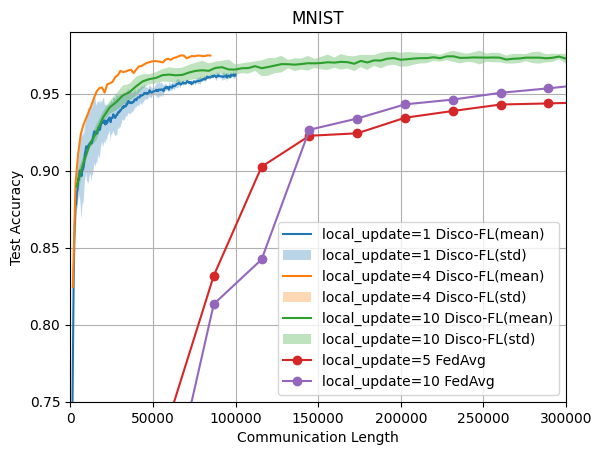

In [186]:
max_iter = 5000
markers = "os*xdXDHhPp12348<>"
# Plot ZO
for i,  local_update in enumerate([1, 4, 10]):
    y_list = []
    for df, metadata in zip(df_list, metadata_list):
        if metadata['local_update'] != local_update:
            continue
        _df = df.query(f"Step <= {max_iter}")
        x = _df['Step'] * metadata['local_update'] * metadata['npert']
        y_list.append(_df['Value'])
    plot_between(x, y_list, local_update=local_update)

# Plot FO
for df, metadata in zip(df_fo_list, metadata_fo_list):
    local_update=metadata['local_update']
    plt.plot(df['Step']*MODEL_SIZE, df['Value'], '-o', label=f"{local_update=} FedAvg")

plt.ylim(0.75, 0.99)
plt.xlim(-200, 300000)
plt.grid(True)
plt.xlabel("Communication Length")
plt.ylabel("Test Accuracy")
plt.title("MNIST")
plt.legend()
plt.show()

## MNIST with perturbation

Base command (changing num-pert from [10, 20, 40])
```
python cezo_fl_main.py --local-update=4 --dataset=mnist --log-to-tensorboard=True --lr=0.0005 --seed=99 --iterations=10000 --num-pert=40 --momentum=0.9 --num-clients=100 --num-sample-clients=10
```

In [250]:
# Load ZO dataset
zo_filenames = os.listdir("mnist_zo_fedavg")

df_list = []
metadata_list = []
for filename in sorted(zo_filenames):
    if "lr-0.0005" not in filename:
        continue
    df_list.append(pd.read_csv(f"mnist_zo_fedavg/{filename}"))
    metadata = parse_filename(filename)
    metadata['type'] = "accuracy" if "Accuracy" in filename else "loss"
    metadata_list.append(metadata)

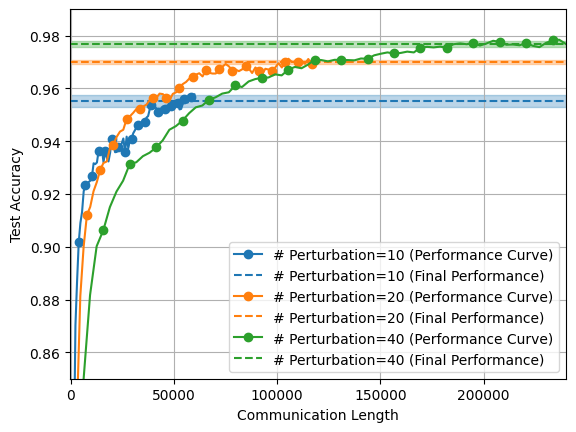

In [286]:
i = 0 # for color
xmin = -200
xmax = 240000
for df, metadata in zip(df_list, metadata_list):
    if metadata['type'] != "accuracy":
        continue
    npert=metadata['npert']
    _df = df.query(f"Step <= {1500}")
    plt.plot(_df['Step'] * metadata["local_update"] * metadata["npert"], 
             _df['Value'], '-o', label=f"# Perturbation={npert} (Performance Curve)",
             markevery=4, color=f"C{i}")
    y_list = list(_df['Value'])[-10:]
    y_mean = np.mean(y_list)
    y_std = np.std(y_list)
    plt.plot([xmin, xmax], [y_mean, y_mean], '--', color=f"C{i}", label=f"# Perturbation={npert} (Final Performance)")
    plt.fill_between([xmin, xmax], [y_mean-1.28*y_std, y_mean-1.28*y_std],
                     [y_mean+1.28*y_std, y_mean+1.28*y_std], alpha=0.3, color=f"C{i}")
    i+=1


plt.xlabel("Communication Length")
plt.ylabel("Test Accuracy")
plt.ylim(0.85, 0.99)
plt.xlim(xmin, xmax)
plt.grid(True)

    
plt.legend()
plt.show()

In [264]:
list(_df['Value'])[-1]

0.9576999545097352

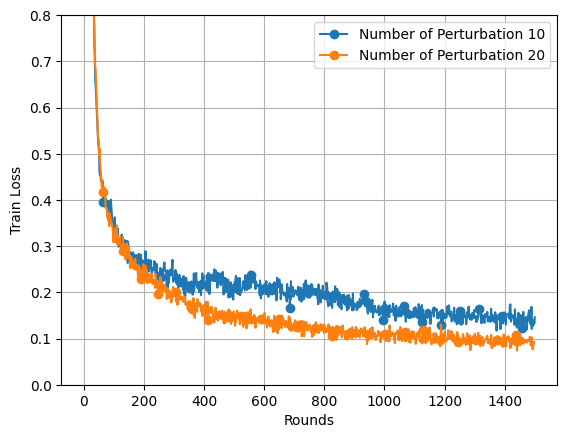

In [252]:
for df, metadata in zip(df_list, metadata_list):
    if metadata['type'] != "loss":
        continue
    npert=metadata['npert']
    _df = df.query(f"Step <= {1500}")
    plt.plot(_df['Step'],  _df['Value'], '-o', label=f"Number of Perturbation {npert}", 
             markevery=40)
plt.ylim(-0.0, 0.8)
# plt.xlim(-200, 120000)
plt.xlabel("Rounds")
plt.ylabel("Train Loss")
plt.grid(True)
plt.legend()
plt.show()